In [34]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from data_treatment import DataSet, DataAtts
from discriminator import *
from generator import *
import os  
# import ipywidgets as widgets
# from IPython.display import display
# import matplotlib.pyplot as plt
import glob
from utils import *
    

class Architecture():
    def __init__(self, learning_rate, batch_size, loss, hidden_layers, name):
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        self.loss=loss
        self.hidden_layers=hidden_layers
        self.name=name

def save_model(name, epoch, attributes, dictionary, optimizer_dictionary, loss_function, db_name, arch_name):
    torch.save({
        'epoch': epoch,
        'model_attributes': attributes,
        'model_state_dict': dictionary,
        'optimizer_state_dict': optimizer_dictionary,
        'loss': loss_function
    }, "models/" + db_name + "/" + name + "_" + arch_name + ".pt")


# Check if creditcard.csv exists and if so, create a scalonated version of it
# escalonate_creditcard_db()
if not os.path.isfile('./original_data/diabetes_escalonated.csv'):
    print("Database creditcard.csv not found, exiting...")
    exit()

file_names=["original_data/diabetes_escalonated.csv"]
num_epochs=[500]
learning_rate=[0.0002]
batch_size=[5]
number_of_experiments = 5
#hidden_layers=[[256, 512]]
hidden_layers=[[256, 512], [256], [128, 256], [128]]
# hidden_layers=[[256]]

#create the different architetures
architectures=[]
count=0
for lr in learning_rate:
    for b_size in batch_size:
        for hidden in hidden_layers:
            for i in range(number_of_experiments):
                name = "id-" + str(count)
                name += "_epochs-" + str(num_epochs[0])
                name += "_layer-" + str(len(hidden))
                name += "_lr-" + str(lr)
                name += "_batch-" + str(b_size)
                name += "_arc-" + ','.join(map(str, hidden))
                architectures.append( Architecture(
                        learning_rate=lr,
                        batch_size=b_size,
                        loss=nn.BCELoss(),
                        hidden_layers=hidden,
                        name=name
                    )
                )
                count+=1

for arc in architectures:
    print(arc)
#training process
for file_name, epochs in zip(file_names, num_epochs):
    dataAtts = DataAtts(file_name)
    database = DataSet (csv_file=file_name, root_dir=".", shuffle_db=False)
    
    for arc in architectures:
        if ("escalonated" in file_name):
            esc = torch.nn.Sigmoid()
        else:
            esc = False

        generatorAtts = {
            'out_features':dataAtts.class_len, 
            'leakyRelu':0.2, 
            'hidden_layers':arc.hidden_layers,
            'in_features':100, 
            'escalonate':esc
        }
        generator = GeneratorNet(**generatorAtts)

        discriminatorAtts = {
            'in_features':dataAtts.class_len,
            'leakyRelu':0.2,
            'dropout':0.3,
            'hidden_layers':arc.hidden_layers[::-1]
        
        }
        discriminator = DiscriminatorNet(**discriminatorAtts)

        if torch.cuda.is_available():
            discriminator.cuda()
            generator.cuda()
        d_optimizer = optim.Adam(discriminator.parameters(), lr=arc.learning_rate)
        g_optimizer = optim.Adam(generator.parameters(), lr=arc.learning_rate)
        loss = arc.loss
        data_loader = torch.utils.data.DataLoader(database, batch_size=arc.batch_size, shuffle=True)
        num_batches = len(data_loader)

        print(dataAtts.fname)
        print(arc.name)
        
        d_error_plt = []
        g_error_plt = []
        
        for epoch in range(epochs):
            if (epoch % 100 == 0):
                print("Epoch ", epoch)

            for n_batch, real_batch in enumerate(data_loader):
                # 1. Train DdataAtts.fnameiscriminator
                real_data = Variable(real_batch).float()
                if torch.cuda.is_available(): 
                    real_data = real_data.cuda()
                # Generate fake data
                fake_data = generator(random_noise(real_data.size(0))).detach()
                # Train D
                d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, discriminator, loss, real_data, fake_data)

                # 2. Train Generator
                # Generate fake data
                fake_data = generator(random_noise(real_batch.size(0)))
                # Train G
                g_error = train_generator(g_optimizer, discriminator, loss, fake_data)
                
                d_error_plt.append(d_error)
                g_error_plt.append(g_error)
                
        # Display Plots
        plt.plot(d_error_plt, 'b')
        plt.plot(g_error_plt, 'r')
        filename = "results/" + dataAtts.fname + "/" + "error_growth.txt"
        file = open(filename, "w")
        file.write("Discriminator error: " + str(d_error_plt) + "\n")
        file.write("\n\n\n")
        file.write("Generator error: " + str(g_error_plt) + "\n")
        file.close()

        plt.savefig('images/'+ dataAtts.fname + "/"+ 'error.png')
        plt.show()
        plt.clf()
                
                
        # From this line on it's just the saving
        # save_model("generator", epoch, generatorAtts, generator.state_dict(), g_optimizer.state_dict(), loss, dataAtts.fname, arc.name)
        # save_model("discriminator", epoch, discriminatorAtts, discriminator.state_dict(), d_optimizer.state_dict(), loss, dataAtts.fname, arc.name)

        torch.save({
            'epoch': epoch,
            'model_attributes': generatorAtts,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': loss
            }, "models/" + dataAtts.fname + "/generator_" + arc.name + ".pt")

        torch.save({
            'epoch': epoch,
            'model_attributes': discriminatorAtts,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'loss': loss
        }, "models/" + dataAtts.fname + "/discriminator_" + arc.name + ".pt")

diabetes_escalonated
id-0_epochs-500_layer-2_lr-0.0002_batch-5_arc-256,512
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
diabetes_escalonated
id-1_epochs-500_layer-2_lr-0.0002_batch-5_arc-256,512
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
diabetes_escalonated
id-2_epochs-500_layer-2_lr-0.0002_batch-5_arc-256,512
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
diabetes_escalonated
id-3_epochs-500_layer-2_lr-0.0002_batch-5_arc-256,512
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
diabetes_escalonated
id-4_epochs-500_layer-2_lr-0.0002_batch-5_arc-256,512
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
diabetes_escalonated
id-5_epochs-500_layer-1_lr-0.0002_batch-5_arc-256
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
diabetes_escalonated
id-6_epochs-500_layer-1_lr-0.0002_batch-5_arc-256
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
diabetes_escalonated
id-7_epochs-500_layer-1_lr-0.0002_batch-5_arc-256
Epoch  0
Epoch  100
Epoch  200
Epoch  300

FileNotFoundError: ignored

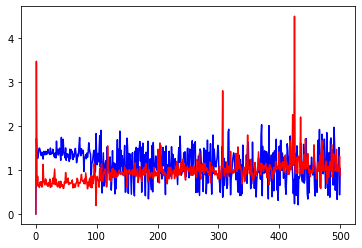

In [39]:
//TODO:Fix the plots 

plt.plot(d_error_plt, 'b')
plt.plot(g_error_plt, 'r')
filename = "results/" + dataAtts.fname + "/" + "error_growth.txt"
file = open(filename, "w")
file.write("Discriminator error: " + str(d_error_plt) + "\n")
file.write("\n\n\n")
file.write("Generator error: " + str(g_error_plt) + "\n")
file.close()

plt.savefig('images/'+ dataAtts.fname + "/"+ 'error.png')
plt.show()
plt.clf()